In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re


import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sharath\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
dft = pd.read_csv('train_data.csv')

In [3]:
dft.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   
2                    Health & Sports    Health & Wellness, Team Sports   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0

In [4]:
dfr = pd.read_csv('resources.csv')

In [5]:
dfr.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [6]:
print(dft.columns)

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')


In [7]:
print(dft.columns)
print(dfr.columns)

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')
Index(['id', 'description', 'quantity', 'price'], dtype='object')


In [8]:
print(dft.shape)
print(dfr.shape)

(109248, 17)
(1541272, 4)


In [9]:
dft['project_is_approved'].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

## 1.2 Data Analysis

In [10]:
y_value_counts = dft['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


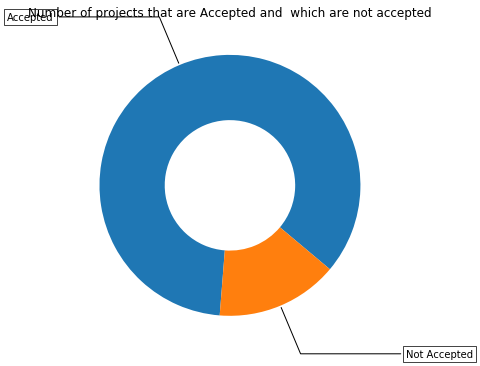

In [11]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of projects that are Accepted and  which are not accepted")

plt.show()

## Univariate Analysis : School State

In [12]:
temp = pd.DataFrame(dft.groupby('school_state')['project_is_approved'].apply(np.mean)).reset_index()

In [13]:
temp.columns = ['state_code', 'num_proposals']

In [14]:
temp.columns

Index(['state_code', 'num_proposals'], dtype='object')

In [15]:
from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [16]:
# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')

In [17]:
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245


In [18]:
print("States with highest % approvals")
print(temp.tail(5))

States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


##SUMMARY :

Delaware (DE) state from the United States has the highest percent of projects accepted within the whole country having almost 90% acceptance rate, followed by North Dakota (ND) and Washington (WA) nearly 89% and 88% respectively each. Vermont (VT) has the lowest Approval rate with exactly 80% followed by District of Columbia (DC) and Texas (TX) with nearly 80% and 81% respectively.


In [19]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [20]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(dft.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(dft.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(dft.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

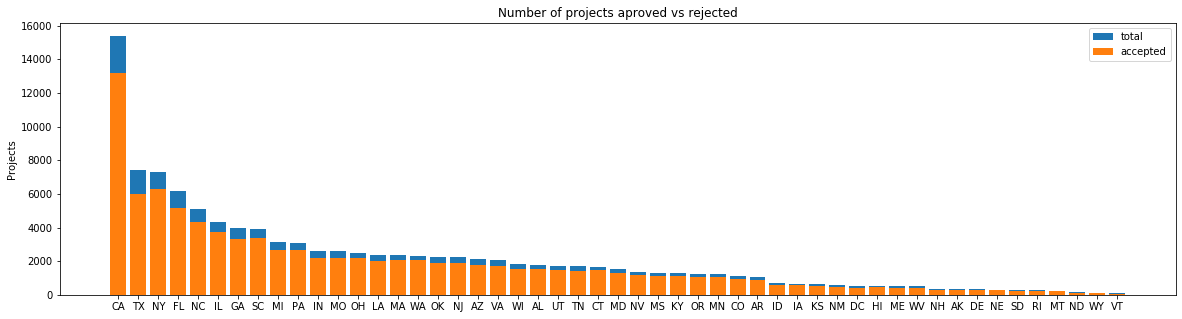

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [21]:
univariate_barplots(dft, 'school_state', 'project_is_approved', False)

##SUMMARY :

    Every state has greater than 80% success rate in approval.
    There is a lot of variability in the number of projects that have been submitted across the States.
    California(CA) has the highest number of project proposals when compared to the other states, Surprisingly, 85% of the projects gets approved on an average which is nearly 13205 out of 15388 project proposals.
    Vermont(VT) has the lowest number of project proposals initiated (80) and almost 80% of the project proposal gets acceptance (64 out of 80). Well, in terms of rejection only 16 were rejected.



## Univariate Analysis : teacher_prefix

In [22]:
dft['teacher_prefix'] = dft['teacher_prefix'].apply(lambda x: np.str_(x))

In [23]:
teacher_prefix = list(dft['teacher_prefix'].values)

teacher_prefix_list = []

for prefix in teacher_prefix:
    prefix = prefix.replace('.','')
    teacher_prefix_list.append(prefix.lower())

dft['teacher_prefix'] = teacher_prefix_list

In [24]:
clean_teacher_prefix = list(dft['teacher_prefix'].values)
print(list(set(clean_teacher_prefix)))

['nan', 'teacher', 'ms', 'mrs', 'mr', 'dr']


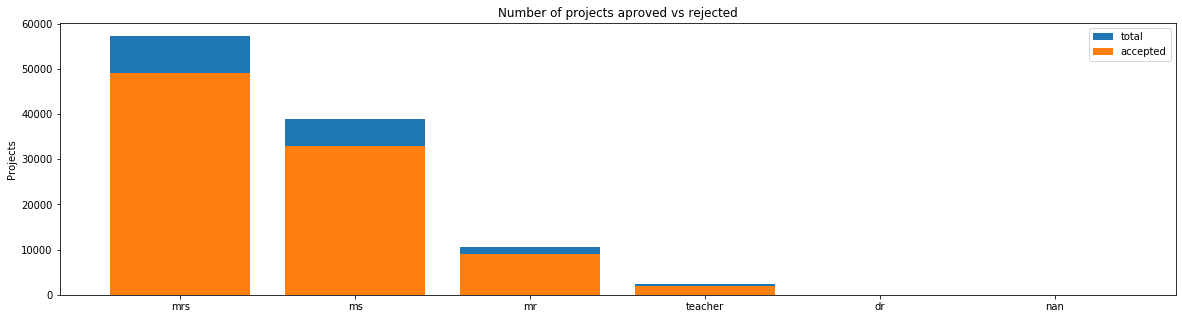

  teacher_prefix  project_is_approved  total       Avg
2            mrs                48997  57269  0.855559
3             ms                32860  38955  0.843537
1             mr                 8960  10648  0.841473
5        teacher                 1877   2360  0.795339
0             dr                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
3             ms                32860  38955  0.843537
1             mr                 8960  10648  0.841473
5        teacher                 1877   2360  0.795339
0             dr                    9     13  0.692308
4            nan                    3      3  1.000000


In [25]:
univariate_barplots(dft, 'teacher_prefix', 'project_is_approved' , top=False)

##SUMMARY :

Female Teachers have the maximum number of projects proposed and accepted compared to the male teachers.
Teachers with prefixes Mrs. , which means Married Women as teachers have a higher number of projects Proposed as well as accepted when compared to the younger Unmarried Women Teachers.
Teachers with Dr. title have proposed hardly 13 projects and out of which 9 of them have been approved.


## Univariate Analysis : project_grade_category

In [26]:
# I am going to put all the values into lowercase.
project_grade_category = list(dft['project_grade_category'].values)

project_grade_category_list = []

for pgc in project_grade_category:
    pgc = pgc.lower()
    pgc_replace = pgc.replace(' ', '_')
    pgc_final_replace = pgc_replace.replace('-', '_')
    
    project_grade_category_list.append(pgc_final_replace)
    
dft['project_grade_category'] = project_grade_category_list

In [27]:
# Check the final result
clean_project_grade_category = list(dft['project_grade_category'].values)
print(list(set(clean_project_grade_category)))

['grades_prek_2', 'grades_9_12', 'grades_6_8', 'grades_3_5']


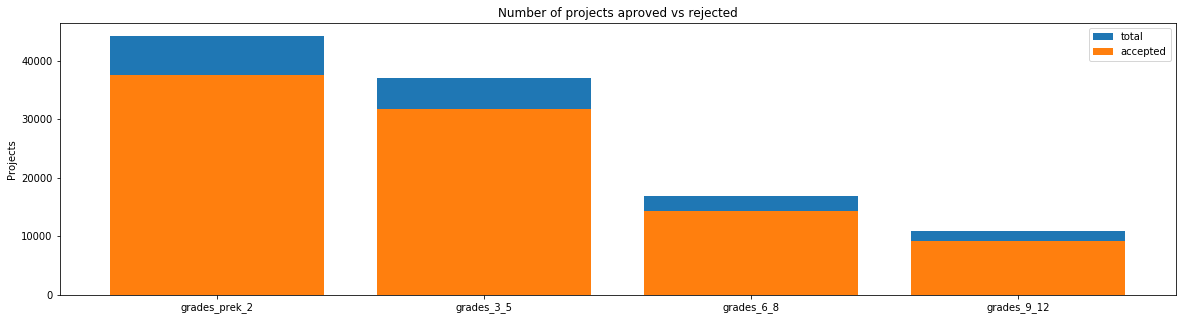

  project_grade_category  project_is_approved  total       Avg
3          grades_prek_2                37536  44225  0.848751
0             grades_3_5                31729  37137  0.854377
1             grades_6_8                14258  16923  0.842522
2            grades_9_12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          grades_prek_2                37536  44225  0.848751
0             grades_3_5                31729  37137  0.854377
1             grades_6_8                14258  16923  0.842522
2            grades_9_12                 9183  10963  0.837636


In [28]:
univariate_barplots(dft, 'project_grade_category', 'project_is_approved', top=False)

##SUMMARY :

    There are alot of projects proposed for the students between Pre Kindergarden and 2nd Grade while for the rest it keeps decreasing.
    The average Acceptance rate of the project is 84% irrespective of the Grade.
    We also notice that Students between the 9th Grade and 12th Grade have the lowest number of projects proposed as well as accepted.



## Univariate Analysis: project_subject_categories

In [29]:
categories = pd.Series(dft['project_subject_categories'].values)
print(categories.value_counts())

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

In [30]:
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [31]:
dft['clean_categories'] = cat_list
dft.drop(['project_subject_categories'], axis=1, inplace=True)
dft.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            mrs   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             mr   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0             ms   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          grades_prek_2   
1           FL        2016-10-25 09:22:10             grades_6_8   
2           AZ        2016-08-31 12:03:56             grades_6_8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   
2    Health & Wellness, Team Sports   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports  
2                 Health_Sports

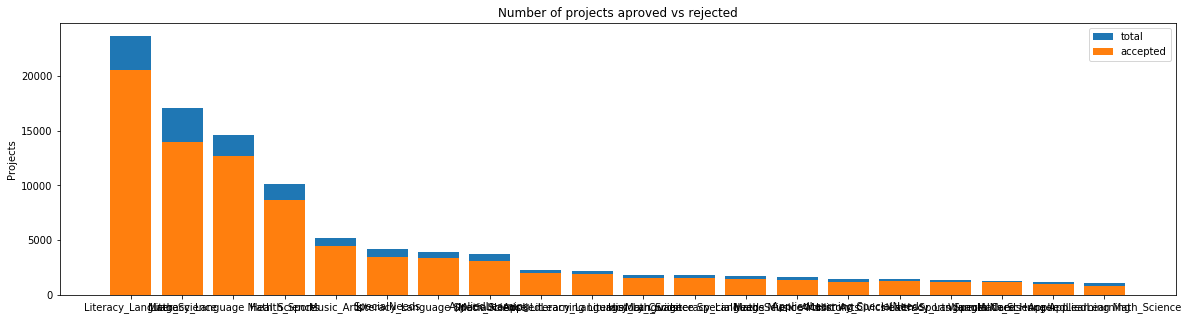

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [32]:
univariate_barplots(dft, 'clean_categories', 'project_is_approved', top=20)

##SUMMARY :

    Projects belonging to the Literacy and Language categories have the highest number of projects proposed under. The maximum number of accepted projects also belong to this category, having an acceptance rate of nearly 87%.
    Projects belonging to both Maths and Science have acceptance rate of nearly 82% while introducing the concept of Literacy and Language to this can increase its accpetance rate to nearly 87%
    There is a lot of variablity in the total number of projects proposed per Category of the project.
    Projects belonging to both Maths and Science when combined with Applied Learning has the least number of projects proposed as well approved.
    There is also Variability in Acceptance rate, projects under the category Warmth, Care and Hunger have an acceptance rate of 93.5%

In [33]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in dft['clean_categories'].values:
    my_counter.update(word.split())

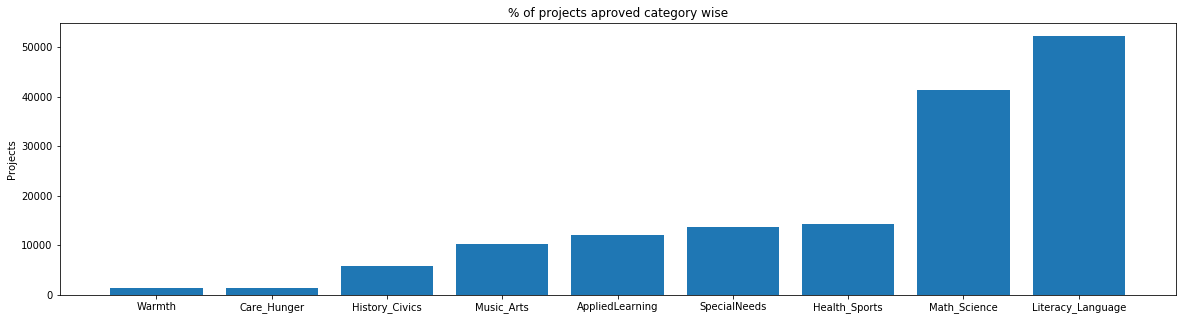

In [34]:
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [35]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


##SUMMARY (While Considering individual Categories for each project) :

    The highest number of projects are registered under Literacy and Language with 52,239 projects, followed by Maths and Science having 41,421 projects.
    There are only 1388 projects under the category of Warmth , Care or Hunger

## Univariate Analysis: project_subject_subcategories

In [36]:
sub_categories = list(dft['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_categories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [37]:
dft['clean_subcategories'] = sub_cat_list
dft.drop(['project_subject_subcategories'], axis=1, inplace=True)
dft.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            mrs   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             mr   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          grades_prek_2   
1           FL        2016-10-25 09:22:10             grades_6_8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

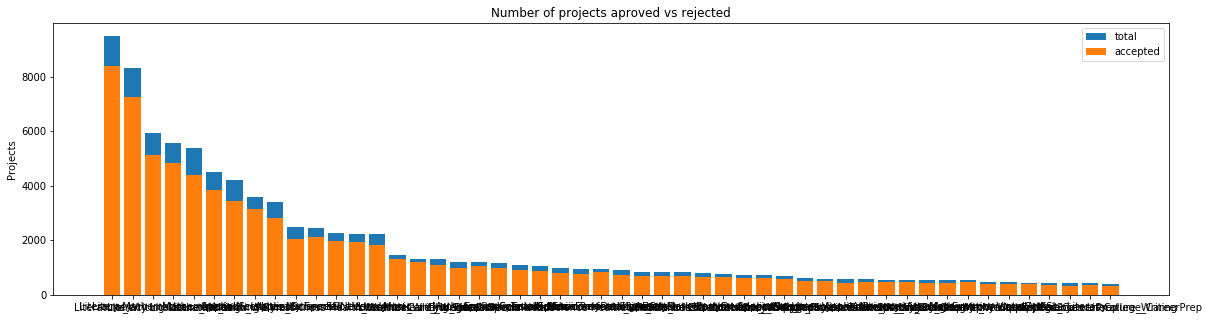

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [38]:
univariate_barplots(dft, 'clean_subcategories', 'project_is_approved', top=50)

##SUMMARY :

    The sub-Category Literacy has the highest number of projects approved with 8371 projects. Also the acceptance rate is 88%.
    The sub-Category Health and Wellness have the lowest number of projects proposed with 3,583 projects only.



In [39]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in dft['clean_subcategories'].values:
    my_counter.update(word.split())

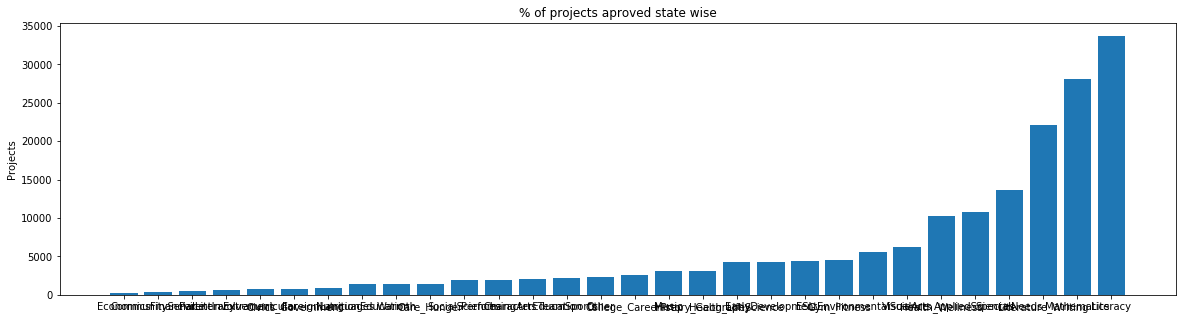

In [40]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [41]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


## Univariate Analysis Text features (Title)

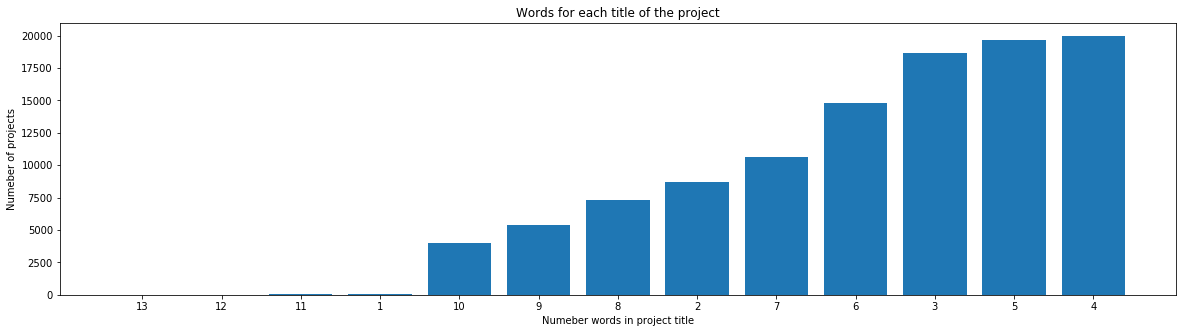

In [42]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = dft['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

##SUMMARY :

    Most of the projects have 4 words in the title. 2.There are hardly any project titles containing more than 10 words. 3.Roughly most of the projects have 3, 4 or 5 words in the title.



In [43]:
approved_title_word_count = dft[dft['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = dft[dft['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

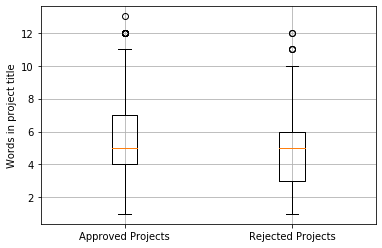

In [44]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

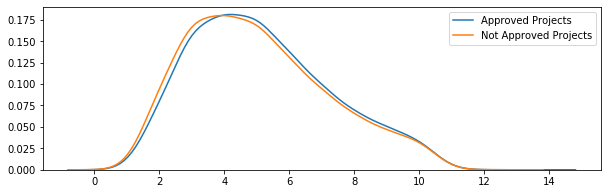

In [45]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

## Univariate Analysis: Text features (Project Essay's)

In [46]:
# merge two column text dataframe: 
dft["essay"] = dft["project_essay_1"].map(str) +\
                        dft["project_essay_2"].map(str) + \
                        dft["project_essay_3"].map(str) + \
                        dft["project_essay_4"].map(str)

In [47]:
approved_word_count = dft[dft['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = dft[dft['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

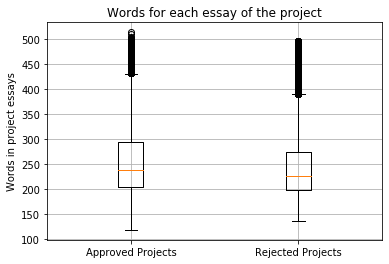

In [48]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

##SUMMARY : 
Approved projects have a slightly more number of words in the project essays when compared to the projects that have not been approved. 
This difference can be noticed in the percentile difference after the 50.0

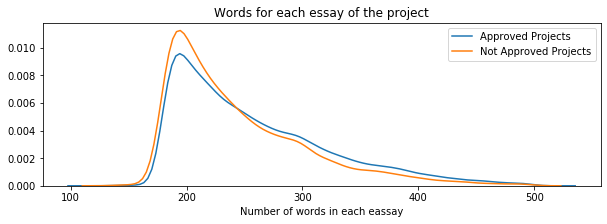

In [49]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

##SUMMARY : The number of words in the Project Essays of Approved Projects are slightly more than the number of words in the Project Essays of the Rejected Projects. This can be noticed by looking at the Blue Line (PDF Curve of Approved Projects) which is denser for words more than 240 to almost 480 or 500.

## Univariate Analysis: Cost per project

In [50]:
dfr.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [51]:
price_data = dfr.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [52]:
# join two dataframes in python: 
dft = pd.merge(dft, price_data, on='id', how='left')

In [53]:
approved_price = dft[dft['project_is_approved']==1]['price'].values

rejected_price = dft[dft['project_is_approved']==0]['price'].values

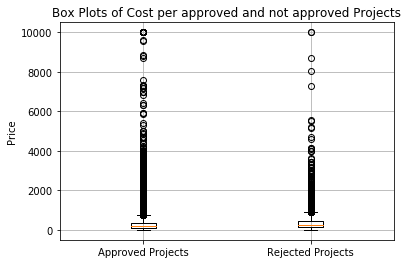

In [54]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

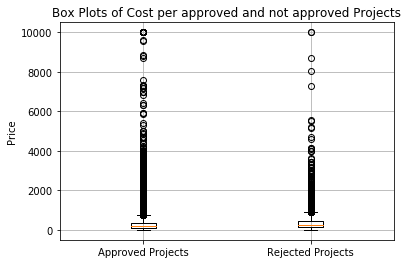

In [55]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

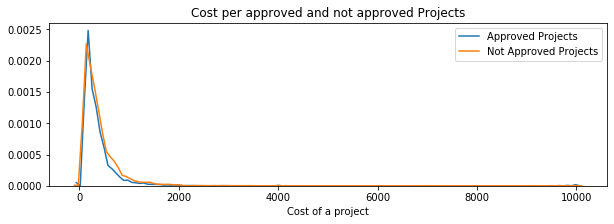

In [56]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

##SUMMARY : Not much can be understood from the box plot depicting the Cost involved per project. We can generalise from the PDF curves that mostly Projects that are very costly are usually not approved.

In [57]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

## Univariate Analysis: teacher_number_of_previously_posted_projects

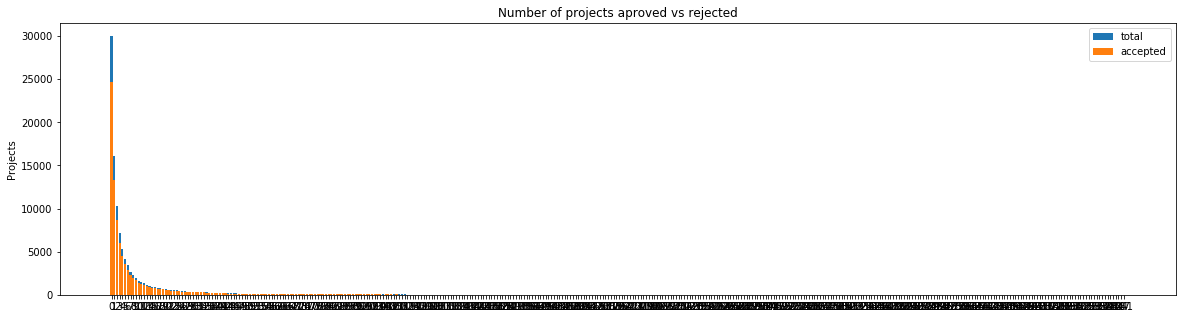

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
     teacher_number_of_previously_posted_projects  project_is_approved  total  \
242                                           242                    1      1   
268                                           270                    1      1   
234                                           234                    1      1   
335                                           347                    1      1   
373                                 

In [58]:
univariate_barplots(dft, 'teacher_number_of_previously_posted_projects', 'project_is_approved' , top=False)

##SUMMARY : 1.We observe that it is not mandatory for a teacher to have proposed any project prior. Maximum number of teachers, nearly 82% of the approved projects have been submitted by teachers with no prior project proposals. New talent and efforts are well appreciated. 2.Very few teachers who have proposed more than 20 projects have got approval. But the rate of approval is Higher given the teacher has proposed atleast 19 different projects. 3.There is alot of variability in the number of projects previously proposed by the teacher varying from 0 to more than 20.

## project_resource_summary

In [59]:
## Let us separate the data and carry out our work only on the required Project Resource Summaries.

summaries = []

for a in dft["project_resource_summary"] :
    summaries.append(a)
    
summaries[0:10]



['My students need opportunities to practice beginning reading skills in English at home.',
 'My students need a projector to help with viewing educational programs',
 'My students need shine guards, athletic socks, Soccer Balls, goalie gloves, and training materials for the upcoming Soccer season.',
 'My students need to engage in Reading and Math in a way that will inspire them with these Mini iPads!',
 'My students need hands on practice in mathematics. Having fun and personalized journals and charts will help them be more involved in our daily Math routines.',
 'My students need movement to be successful. Being that I have a variety of students that have all different types of needs, flexible seating would assist not only these students with special needs, but all students.',
 'My students need some dependable laptops for daily classroom use for reading and math.',
 'My students need ipads to help them access a world of online resources that will spark their interest in learning.',

In [60]:
## Identifying the numbers from the project summaries and storing the values as a key value pair in a dictionary to 
## avoid missing the position of the value within the huge ocean of summary data.

numeric_summary_values = {}

for x in tqdm(range(len(summaries))):
    for s in summaries[x].split():
        if s.isdigit() :
            numeric_summary_values[x] = int(s)

100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 189171.34it/s]


In [61]:
numeric_summary_values[14]

5

In [62]:
## We only have the key value pairs for Summaries containing Numeric values, so in this step 

numeric_digits = {}

for c in range(len(summaries)) :
    if c in numeric_summary_values.keys() :
        numeric_digits[c] = numeric_summary_values[c]
    else :
        numeric_digits[c] = 0

In [63]:
for i in range (20) :
    print(numeric_digits[i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
5
0
2
0
0
7


In [64]:
len(numeric_digits)

109248

In [65]:
## Converting the key value pairs to 1 or 0 based on presence of Numeric Values.

digit_in_summary = []

for a in numeric_digits.values() :
    if a > 0 :
        digit_in_summary.append(1)
    else :
        digit_in_summary.append(0)

In [66]:
digit_in_summary[0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]

In [67]:
dft['digit_in_summary'] = digit_in_summary

dft.head(20)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0       160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            mrs   
1       140945  p258326  897464ce9ddc600bced1151f324dd63a             mr   
2        21895  p182444  3465aaf82da834c0582ebd0ef8040ca0             ms   
3           45  p246581  f3cb9bffbba169bef1a77b243e620b60            mrs   
4       172407  p104768  be1f7507a41f8479dc06f047086a39ec            mrs   
5       141660  p154343  a50a390e8327a95b77b9e495b58b9a6e            mrs   
6        21147  p099819  9b40170bfa65e399981717ee8731efc3            mrs   
7        94142  p092424  5bfd3d12fae3d2fe88684bbac570c9d2             ms   
8       112489  p045029  487448f5226005d08d36bdd75f095b31            mrs   
9       158561  p001713  140eeac1885c820ad5592a409a3a8994             ms   
10       43184  p040307  363788b51d40d978fe276bcb1f8a2b35            mrs   
11      127083  p251806  4ba7c721133ef651ca54a03551746708             ms   
12       19090  p051126  5e52c92b7e3c472aad247a239d345543            mrs   
13       15126  p003874  178f6ae765cd4e0fb143a77c47fd65e2            mrs   
14       62232  p233127  424819801de22a60bba7d0f4354d0258             ms   
15       67303  p132832  bb6d6d054824fa01576ab38dfa2be160             ms   
16      127215  p174627  4ad7e280fddff889e1355cc9f29c3b89            mrs   
17      157771  p152491  e39abda057354c979c5b075cffbe5f88             ms   
18      122186  p196421  fcd9b003fc1891383f340a89da02a1a6            mrs   
19      146331  p058343  8e07a98deb1bc74c75b97521e05b1691             ms   

   school_state project_submitted_datetime project_grade_category  \
0            IN        2016-12-05 13:43:57          grades_prek_2   
1            FL        2016-10-25 09:22:10             grades_6_8   
2            AZ        2016-08-31 12:03:56             grades_6_8   
3            KY        2016-10-06 21:16:17          grades_prek_2   
4            TX        2016-07-11 01:10:09          grades_prek_2   
5            FL        2017-04-08 22:40:43             grades_3_5   
6            CT        2017-02-17 19:58:56             grades_6_8   
7            GA        2016-09-01 00:02:15             grades_3_5   
8            SC        2016-09-25 17:00:26          grades_prek_2   
9            NC        2016-11-17 18:18:56          grades_prek_2   
10           CA        2017-01-04 16:40:30             grades_3_5   
11           CA        2016-11-14 22:57:28          grades_prek_2   
12           NY        2016-05-23 15:46:02             grades_6_8   
13           OK        2016-10-17 09:49:27          grades_prek_2   
14           MA        2017-02-14 16:29:10          grades_prek_2   
15           TX        2016-10-05 21:05:38             grades_3_5   
16           FL        2017-01-18 10:59:05          grades_prek_2   
17           NV        2016-11-23 17:14:17             grades_3_5   
18           GA        2016-08-28 15:04:42          grades_prek_2   
19           OH        2016-08-06 13:05:20             grades_3_5   

                                        project_title  \
0    Educational Support for English Learners at Home   
1               Wanted: Projector for Hungry Learners   
2   Soccer Equipment for AWESOME Middle School Stu...   
3                              Techie Kindergarteners   
4                              Interactive Math Tools   
5   Flexible Seating for Mrs. Jarvis' Terrific Thi...   
6   Chromebooks for Special Education Reading Program   
7                               It's the 21st Century   
8                     Targeting More Success in Class   
9     Just For the Love of Reading--\r\nPure Pleasure   
10                              Reading Changes Lives   
11  Elevating Academics and Parent Rapports Throug...   
12                  Building Life Science Experiences   
13                     Everyone deserves to be heard!   
14                      TABLETS CAN SHOW US THE WORLD   
15                               Making Reces

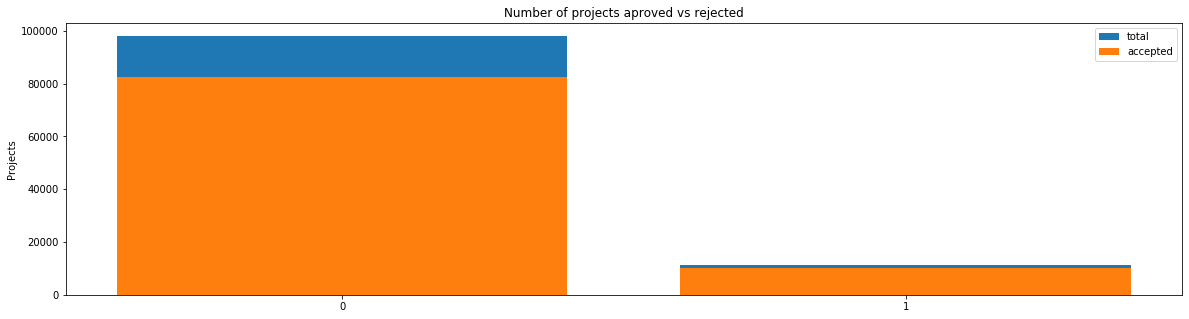

   digit_in_summary  project_is_approved  total       Avg
0                 0                82563  98012  0.842376
1                 1                10143  11236  0.902723
   digit_in_summary  project_is_approved  total       Avg
0                 0                82563  98012  0.842376
1                 1                10143  11236  0.902723


In [68]:
univariate_barplots(dft, 'digit_in_summary', 'project_is_approved', top=2)

##SUMMARY : 1.The project summaries containing numeric values have a very high acceptance rate of 90%. Well, proper numbered requirements suggest clarity in the proposals and hence Alot of people tend to donate for a better cause, that is to help children 2.It is obvious from the graph that majority of the projects do not have numeric values stating the requirement of certain products

## Text preprocessing

## Essay text

In [69]:
dft.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            mrs   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             mr   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0             ms   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60            mrs   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec            mrs   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          grades_prek_2   
1           FL        2016-10-25 09:22:10             grades_6_8   
2           AZ        2016-08-31 12:03:56             grades_6_8   
3           KY        2016-10-06 21:16:17          grades_prek_2   
4           TX        2016-07-11 01:10:09          grades_prek_2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2  ... project_essay_4  \
0  \"The limits of your language are the limits o...  ...             NaN   
1  The projector we need for our school is very c...  ...             NaN   
2  The students on the campus come to school know...  ...             NaN   
3  My students live in high poverty conditions wi...  ...             NaN   
4  For many students, math is a subject that does...  ...             NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   
2  My students need shine guards, athletic socks,...   
3  My students need to engage in Reading and Math...   
4  My students need hands on practice in mathemat...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   
2                                            1                    0   
3                                            4                    1   
4                                            1                    1   

                 clean_categories           clean_subcategories  \
0               Literacy_Language                  ESL Literacy   
1    History_Civics Health_Sports  Civics_Government TeamSports   
2                   Health_Sports    Health_Wellness TeamSports   
3  Literacy_Language Math_Science          Literacy Mathematics   
4                    Math_Science                   Mathematics   

                                               essay   price  quantity  \
0  My students are English learners that are work...  154.60        23   
1  Our students arrive to our school eager to lea...  299.00         1   
2  \r\n\"True champions aren't always the ones th...  516.85        22   
3  I work at a unique school filled with both ESL...  232.90         4   
4  Our second grade classroom next year will be m...   67.98         4   

   digit_in_summary  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 21 columns]

In [70]:
# printing some random essays.
print(dft['essay'].values[0])
print("="*50)
print(dft['essay'].values[150])
print("="*50)
print(dft['essay'].values[1000])
print("="*50)
print(dft['essay'].values[20000])
print("="*50)
print(dft['essay'].values[99999])
print("="*50)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher inspires. -William A. Ward\r\n\r\nMy school has 803 students which is makeup is 97.6% African-American, making up the largest segment of the student body. A typical school in Dallas is made up of 23.2% African-American students. Most of the students are on free or reduced lunch. We aren't receiving doctors, lawyers, or engineers children from rich backgrounds or neighborhoods. As an educator I am inspiring minds of young children and we focus not only on academics but one smart, effective, efficient, and disciplined students with good character.In our classroom we can utilize the Bluetooth for swift transitions during class. I use a speaker which doesn't amplify the sound enough to receive the message. Due to the volume of my speaker my students can't hear videos or books clearly and it isn't making the lessons as meaningful. But with the bluetooth speaker my students will be abl

In [71]:
import re

cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text.lower())

In [72]:
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

In [73]:
def remove_chars(text):
    '''remove uncessary chars'''
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [74]:
custom_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "need", "com","im",
                    "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',"chat","can","transfer",
                    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', "can",
                    'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',"transfer","transferred",
                    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am',"information",
                    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', "reconnecting",
                    'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', "work", "want",
                    'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',"successfully", "try",
                    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', "morning",
                    'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 
                    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 
                    'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'onboarde',
                    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
                    "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'retriggere',
                    'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
                    'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', "say", "retrigger",
                    'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", "employee",     
                    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", "try", "let",
                    'wouldn', "wouldn't",'thank','thanks','ok','yes','support','customer','hi','hello','wont','okay',"could"]

In [75]:
from nltk import word_tokenize, sent_tokenize

def Clean_Text(text):
    clean_text = text.lower()
    clean_text = remove_whitespace(clean_text)
    clean_text = expandContractions(clean_text, c_re=c_re)
    clean_text = re.sub(r':', '', clean_text)
    clean_text = re.sub(r'‚Ä¶', '', clean_text)
    clean_text = re.sub(r'[^\x00-\x7F]+',' ', clean_text)
    clean_text = remove_chars(clean_text)
    clean_text = re.sub(r'\d','',clean_text)
    clean_text = [char for char in clean_text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    tokens = word_tokenize(clean_text)
    result = [i for i in tokens if not i in custom_stopwords]
    return ' '.join(result)

In [76]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentence in tqdm(dft['essay'].values):
    sent = Clean_Text(sentence)
    preprocessed_essays.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [05:03<00:00, 359.46it/s]


In [77]:
# after preprocesing
preprocessed_essays[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays grossfine motor delays autism eager beavers always strive hardest working past limitations rnrnthe materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explorehave ever felt like ants pants needed groove move meeting kids feel time able move learn saywobble chairs answer love develop core enhances gross motor turn fine motor skills rnthey also learn games kids not sit worksheets learn count jumping playing physical engagement key success number toss color shape mats make happen students forget fun year old deservesnannan'

In [78]:
# printing some random essays.
print(dft['project_title'].values[0])
print("="*50)
print(dft['project_title'].values[150])
print("="*50)
print(dft['project_title'].values[1000])
print("="*50)
print(dft['project_title'].values[20000])
print("="*50)
print(dft['project_title'].values[99999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Minds by Enhancing the Educational Experience


In [79]:
preprocessed_titles = []

for titles in tqdm(dft["project_title"]):
    title = Clean_Text(titles)
    preprocessed_titles.append(title)

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:17<00:00, 6077.94it/s]


In [80]:
preprocessed_titles[2000]

'steady stools active learning'

## Preparing Data for Models

In [81]:
dft.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digit_in_summary'],
      dtype='object')

## Vectorizing categorical data

In [82]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(dft['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(dft['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


In [83]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(dft['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(dft['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


In [84]:
#One Hot Encode - School States
my_counter = Counter()
for state in dft['school_state'].values:
    my_counter.update(state.split())

In [85]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [86]:
## we use count vectorizer to convert the values into one hot encoded features

vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(dft['school_state'].values)
print(vectorizer.get_feature_names())

school_state_categories_one_hot = vectorizer.transform(dft['school_state'].values)
print("Shape of matrix after one hot encoding ",school_state_categories_one_hot.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encoding  (109248, 51)


In [87]:
#One Hot Encode - Project Grade Category
my_counter = Counter()
for project_grade in dft['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [88]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [89]:
## we use count vectorizer to convert the values into one hot encoded features

vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(dft['project_grade_category'].values)
print(vectorizer.get_feature_names())

project_grade_categories_one_hot = vectorizer.transform(dft['project_grade_category'].values)
print("Shape of matrix after one hot encoding ",project_grade_categories_one_hot.shape)

['grades_9_12', 'grades_6_8', 'grades_3_5', 'grades_prek_2']
Shape of matrix after one hot encoding  (109248, 4)


In [90]:
#One Hot Encode - Teacher Prefix
my_counter = Counter()
for teacher_prefix in dft['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

teacher_prefix_cat_dict = dict(my_counter)

In [91]:
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [92]:
## we use count vectorizer to convert the values into one hot encoded features
## Unlike the previous Categories this category returns a
## ValueError: np.nan is an invalid document, expected byte or unicode string.
## The link below explains h0w to tackle such discrepancies.
## https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document/39308809#39308809

vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(dft['teacher_prefix'].values.astype("U"))
print(vectorizer.get_feature_names())

teacher_prefix_categories_one_hot = vectorizer.transform(dft['teacher_prefix'].values.astype("U"))
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot.shape)

['nan', 'dr', 'teacher', 'mr', 'ms', 'mrs']
Shape of matrix after one hot encoding  (109248, 6)


## Vectorizing text data

## Bag of Words

In [93]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 22086)


In [94]:
print('''There are {} unique words among the {} number of Project 
      essays, considering atleast 10 different projects has the same word'''.format(text_bow.shape[1], text_bow.shape[0]))

There are 22086 unique words among the 109248 number of Project 
      essays, considering atleast 10 different projects has the same word


## Bag of words on project title

In [95]:
# We are considering only the words which appeared in at least 5 documents(rows or projects).
vectorizer = CountVectorizer(min_df=5)
title_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encoding ",title_bow.shape)

Shape of matrix after one hot encoding  (109248, 4992)


In [96]:
print ('''There are {} unique words among the {} number of project titles, 
considering atleast 5 different projects has the same word'''.format(title_bow.shape[1], title_bow.shape[0]))

There are 4992 unique words among the 109248 number of project titles, 
considering atleast 5 different projects has the same word


## TF-IDF vectorizer

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 22086)


## TF-IDF vectorizer on project title

In [98]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = TfidfVectorizer(min_df=5)
title_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encoding ",title_tfidf.shape)

Shape of matrix after one hot encoding  (109248, 4992)


## Using Pretrained Models: Avg W2V

In [99]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model

In [100]:
model = loadGloveModel('glove.6B.300d.txt')

Loading Glove Model


400000it [02:20, 2850.50it/s]


Done. 400000  words loaded!


In [101]:
words = []

for i in preprocessed_essays :
    words.extend(i.split(' '))
    
for i in preprocessed_titles:
    words.extend(i.split(' '))

In [102]:
print("all the words in the corpus", len(words))

all the words in the corpus 14889283


In [103]:
words = set(words)
print("the unique words in the corpus", len(words))

the unique words in the corpus 191825


In [104]:
inter_words = set(model.keys()).intersection(words)

print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

The number of words that are present in both glove vectors and our coupus 42950 ( 22.39 %)


In [105]:
words_corpus = {}

words_glove = set(model.keys())

for i in words:
    if i in words_glove:
        words_corpus[i] = model[i]

print("word 2 vec length", len(words_corpus))

word 2 vec length 42950


In [106]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_corpus, f)

In [107]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [108]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [109]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:48<00:00, 2239.33it/s]


109248
300


In [110]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles.append(vector)

print(len(avg_w2v_vectors_titles))
print(len(avg_w2v_vectors_titles[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 38852.88it/s]


109248
300


## using pre-trained models :TF-IDF weighted W2V

In [111]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [112]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [05:02<00:00, 360.62it/s]


109248
300


In [113]:
# Similarly you can vectorize for title also

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [114]:
# average Word2Vec
# compute average word2vec for each Project Title
tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title.append(vector)
    
print(len(tfidf_w2v_vectors_title))
print(len(tfidf_w2v_vectors_title[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:04<00:00, 24115.57it/s]


109248
300


## Vectorizing numerical features

## Vectorizing price (Numeric - Data)

In [115]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(dft['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print("Mean : {}".format(price_scalar.mean_[0]))
print("Standard deviation : {}".format(np.sqrt(price_scalar.var_[0])))
# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(dft['price'].values.reshape(-1, 1))

Mean : 298.1193425966608
Standard deviation : 367.49634838483496


In [116]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

##Summary : We observe that on an average Each project costs nearly 298 Dollars. With a Standard Deviation of 368 dollars. So , mostly majority of the projects are less than 1000 Dollars

## Vectorizing Numeric Data (Quantity)

In [117]:
import warnings
warnings.filterwarnings("ignore")

quantity_scalar = StandardScaler()

## Finding the mean and standard deviation of this data
quantity_scalar.fit(dft['quantity'].values.reshape(-1,1)) 

print("Mean : {}".format(quantity_scalar.mean_[0]))

print("Standard deviation : {}".format(np.sqrt(quantity_scalar.var_[0])))

# Now standardize the data with above maen and variance.
quantity_standardized = quantity_scalar.transform(dft['quantity'].values.reshape(-1, 1))

Mean : 16.965610354422964
Standard deviation : 26.182821919093175


In [118]:
quantity_standardized

array([[ 0.23047132],
       [-0.60977424],
       [ 0.19227834],
       ...,
       [-0.4951953 ],
       [-0.03687954],
       [-0.45700232]])

##Summary : The projects on an average require atleast 17 Different of similar items. We observe that the Price paid is generally for the purchase of these Items. Donors can choose on projects to donate based on the Items provided to aid the Students of any Grade

## Vectorizing - Number of Projects Proposed Previously by the Teacher (Numerical Data)

In [119]:
prev_projects_scalar = StandardScaler()

## Finding the mean and standard deviation of this data
prev_projects_scalar.fit(dft['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 

print("Mean : {}".format(prev_projects_scalar.mean_[0]))

print("Standard deviation : {}".format(np.sqrt(prev_projects_scalar.var_[0])))

# Now standardize the data with above maen and variance.
prev_projects_standardized = prev_projects_scalar.transform(dft['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.153165275336848
Standard deviation : 27.77702641477403


In [120]:
prev_projects_standardized

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

##Summary : We observe that Teachers generally on an average propose atleast 11 different projects. Well, The teachers are indeed actively seeking help to aid for the betterment of the students in their locality.


In [121]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 22086)
(109248, 1)


In [122]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(109248, 22126)

## TSNE with BOW encoding of project_title feature (5000 Data Entries)

In [123]:
print("The Shape of Data matrices for Categorical Data are :")
print("\n")
print("The Shape of Data Matrix for different Categories of projects is : {}".format(categories_one_hot.shape))
print("The Shape of Data Matrix for different Sub-categories of projects is : {}".format(sub_categories_one_hot.shape))
print("The Shape of Data Matrix with respect to Projects from a particular State in the United States is : {}".format(school_state_categories_one_hot.shape))
print("The Shape of the Data Matrix of the different projects with respect to the Grades of the students is : {} ".format(project_grade_categories_one_hot.shape))
print("The Shape of the Data Matrix with respect to title of the Teacher proposing the Teacher is : {}".format(teacher_prefix_categories_one_hot.shape))
print("\n")
print("="*100)
print("\n")
print("The Shape of Data matrices for Numerical Data are :")
print("\n")
print("The Shape of the Data Matrix for price of the projects is : {}".format(price_standardized.shape))
print("The Shape of the Data Matrix for Quantity of the items for the projects is : {}".format(quantity_standardized.shape))
print("The Shape of the Data Matrix for the Number of Projects Proposed Previously by the Teacher is : {}".format(prev_projects_standardized.shape))
print("\n")
print("="*100)
print("\n")
print("TITLE BOW : {}".format(title_bow.shape))
print("\n")
print("TITLE TFIDF : {}".format(title_tfidf.shape))
print("\n")
print("TITLE AVG W2V : ({}, {})".format(len(avg_w2v_vectors_titles), len(avg_w2v_vectors_titles[0])))
print("\n")
print("TITLE TFIDF W2V : ({}, {})".format(len(tfidf_w2v_vectors_title), len(tfidf_w2v_vectors_title[0])))

The Shape of Data matrices for Categorical Data are :


The Shape of Data Matrix for different Categories of projects is : (109248, 9)
The Shape of Data Matrix for different Sub-categories of projects is : (109248, 30)
The Shape of Data Matrix with respect to Projects from a particular State in the United States is : (109248, 51)
The Shape of the Data Matrix of the different projects with respect to the Grades of the students is : (109248, 4) 
The Shape of the Data Matrix with respect to title of the Teacher proposing the Teacher is : (109248, 6)




The Shape of Data matrices for Numerical Data are :


The Shape of the Data Matrix for price of the projects is : (109248, 1)
The Shape of the Data Matrix for Quantity of the items for the projects is : (109248, 1)
The Shape of the Data Matrix for the Number of Projects Proposed Previously by the Teacher is : (109248, 1)




TITLE BOW : (109248, 4992)


TITLE TFIDF : (109248, 4992)


TITLE AVG W2V : (109248, 300)


TITLE TFIDF W2V : (10924

In [124]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, 
            project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized, 
            quantity_standardized, prev_projects_standardized, title_bow))
X.shape

(109248, 5095)

In [125]:
from sklearn.manifold import TSNE
X = X.tocsr()
X_new = X[0:5000,:]
X_new = X_new.toarray()
labels = dft["project_is_approved"]
labels_new = labels[0: 5000]
len(labels_new)
# model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
# tsne_data_b = model.fit_transform(X_new)

5000

In [126]:
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new)

In [127]:
tsne_data_b = np.vstack((tsne_data_b.T, labels_new)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))

In [128]:
tsne_df_b.shape

(5000, 3)

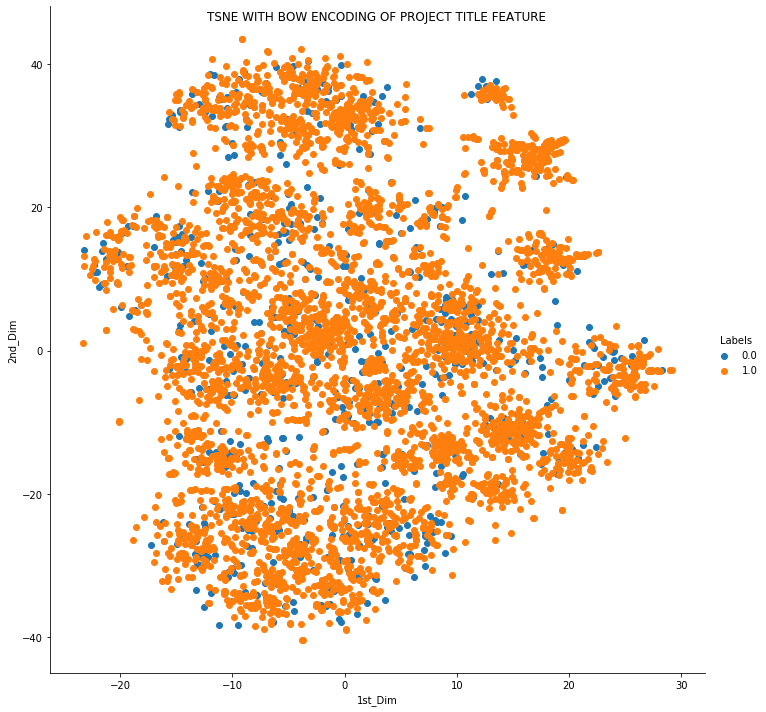

In [129]:
# please write all of the code with proper documentation and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH BOW ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

##Summary : We observe alot of overlapping in the datapoints and the points are well scattered, unable to draw any proper conclusion



## TSNE with TFIDF encoding of project_title feature (5000 Data Entries)

In [130]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, prev_projects_standardized, title_tfidf))
X.shape

(109248, 5095)

In [131]:
X = X.tocsr()
X_new = X[0:5000,:]

In [132]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_tfidf = model.fit_transform(X_new)

In [133]:
tsne_data_tfidf = np.vstack((tsne_data_tfidf.T, labels_new)).T
tsne_df_tfidf = pd.DataFrame(tsne_data_tfidf, columns = ("1st_Dim","2nd_Dim","Labels"))

In [134]:
tsne_df_tfidf.shape

(5000, 3)

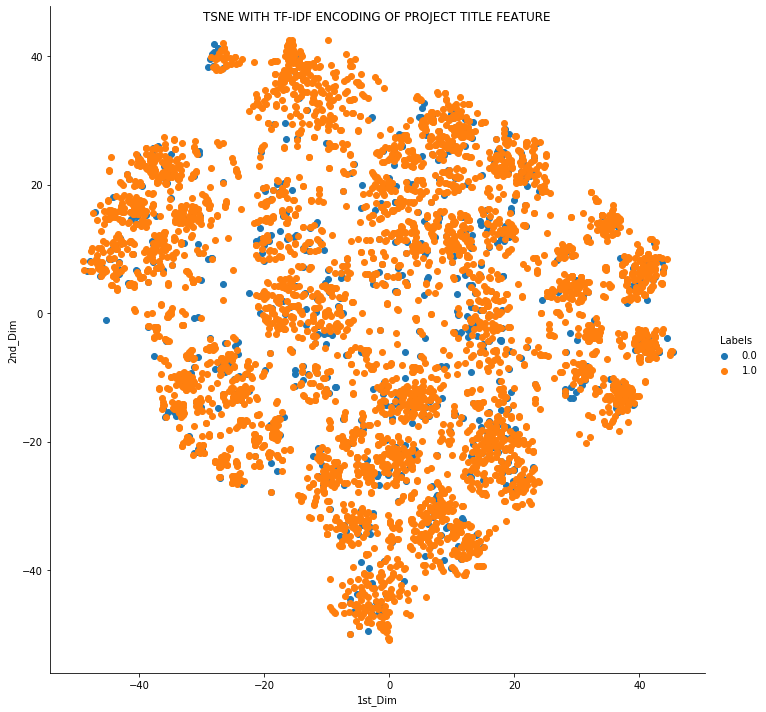

In [135]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

sns.FacetGrid(tsne_df_tfidf, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH TF-IDF ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

##Summary : The Blue and the Orange points do not form any clusters or accumulation of any type, Hence drawing conclusions seems to quite impossible with the current state of the T-SNE data using TF - IDF Encoding

## TSNE with AVG W2V encoding of project_title feature (5000 Data Entries)

In [136]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, prev_projects_standardized, avg_w2v_vectors_titles))
X.shape

(109248, 403)

In [137]:
X = X.tocsr()
X_new = X[0:5000,:]

In [138]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_avg_w2v = model.fit_transform(X_new)

In [139]:
tsne_data_avg_w2v = np.vstack((tsne_data_avg_w2v.T, labels_new)).T
tsne_df_avg_w2v = pd.DataFrame(tsne_data_avg_w2v, columns = ("1st_Dim","2nd_Dim","Labels"))

In [140]:
tsne_df_avg_w2v.shape

(5000, 3)

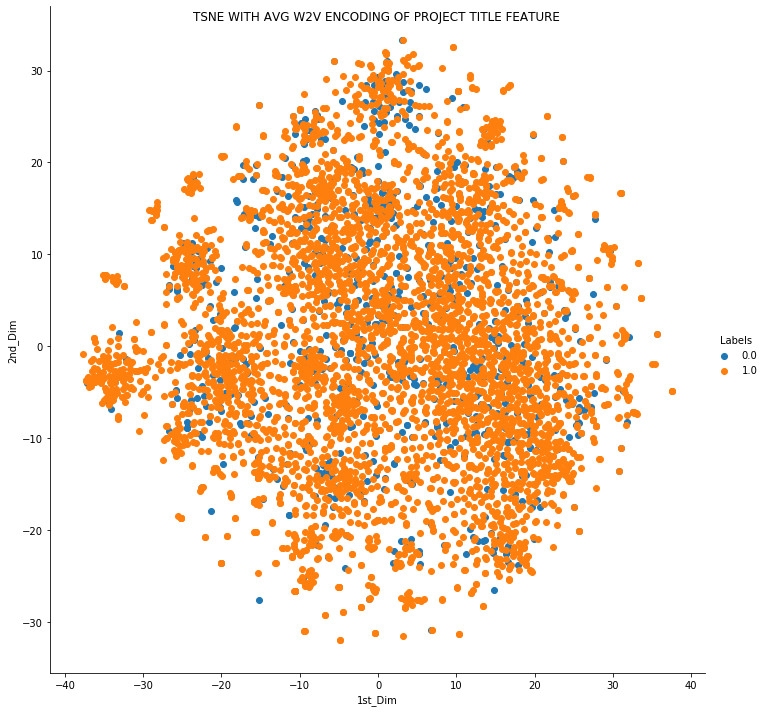

In [141]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

sns.FacetGrid(tsne_df_avg_w2v, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH AVG W2V ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

##Summary : We do not observe any clusters for whether the Project is accepted or not accepted. Hence we are not able to achieve the desired result using Avg- Word2vec

## TSNE with TFIDF Weighted W2V encoding of project_title feature (5000 Data Entries)

In [142]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, prev_projects_standardized, tfidf_w2v_vectors_title))
X.shape

(109248, 403)

In [143]:
X = X.tocsr()
X_new = X[0:5000,:]

In [144]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_tfidf_w2v = model.fit_transform(X_new)

In [145]:
tsne_data_tfidf_w2v = np.vstack((tsne_data_tfidf_w2v.T, labels_new)).T
tsne_df_tfidf_w2v = pd.DataFrame(tsne_data_tfidf_w2v, columns = ("1st_Dim","2nd_Dim","Labels"))

In [146]:
tsne_df_tfidf_w2v.shape

(5000, 3)

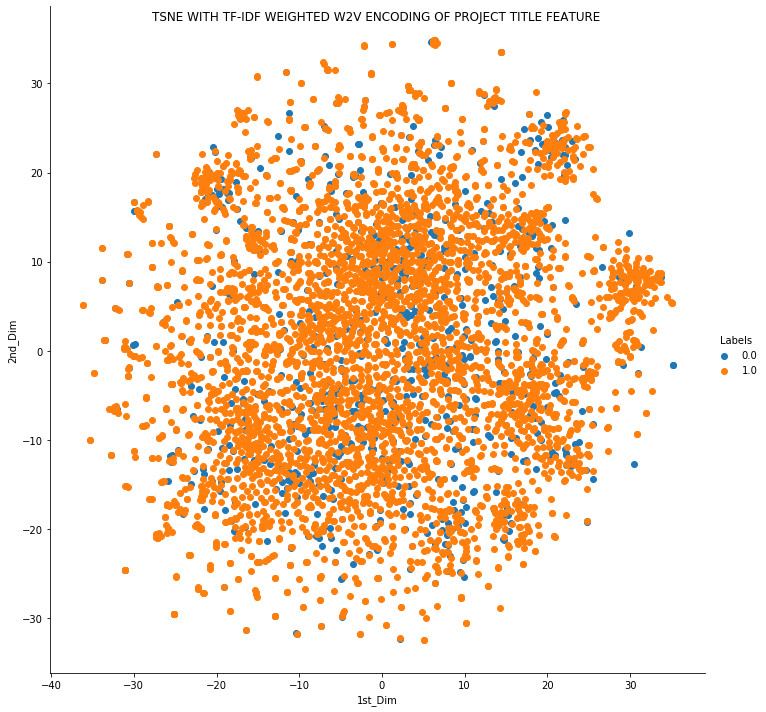

In [147]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
sns.FacetGrid(tsne_df_tfidf_w2v, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH TF-IDF WEIGHTED W2V ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

##Summary :

This visualisation of TSNE with TF-IDF Weighted Word2Vec does not seem to yield the expected result of clustering similar data points. Hence we would have to try any other method


## TSNE with BOW, TFIDF, AVG W2V, TFIDF Weighted W2V encoding of project_title feature (5000 Data Entries)

In [148]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot, project_grade_categories_one_hot, teacher_prefix_categories_one_hot, price_standardized, quantity_standardized, prev_projects_standardized, title_bow, title_tfidf, avg_w2v_vectors_titles, tfidf_w2v_vectors_title))
X.shape

(109248, 10687)

In [149]:
X = X.tocsr()
X_new = X[0:5000,:]

In [150]:
X_new = X_new.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_complete = model.fit_transform(X_new)

In [151]:
tsne_data_complete = np.vstack((tsne_data_complete.T, labels_new)).T
tsne_df_complete = pd.DataFrame(tsne_data_complete, columns = ("1st_Dim","2nd_Dim","Labels"))

In [152]:
tsne_df_complete.shape

(5000, 3)

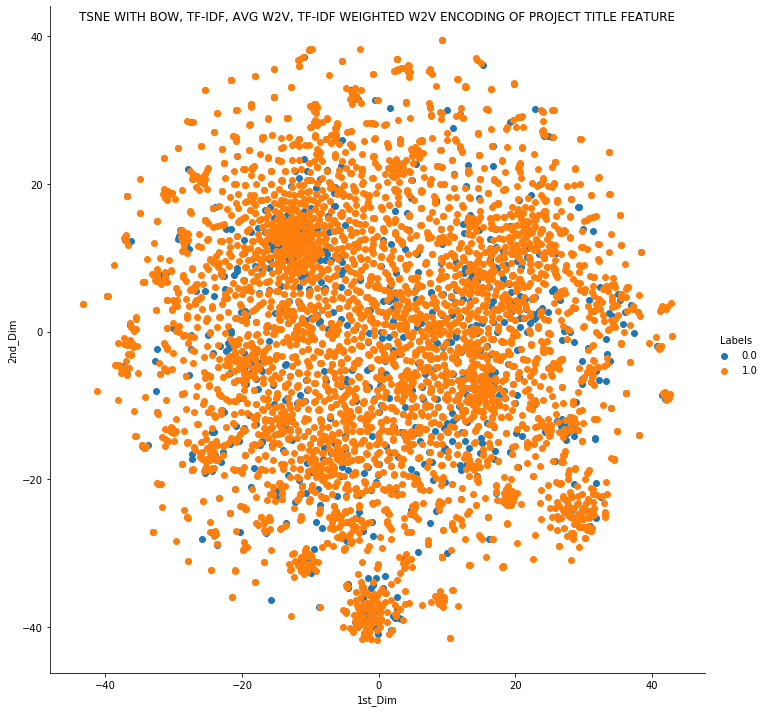

In [153]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
sns.FacetGrid(tsne_df_complete, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH BOW, TF-IDF, AVG W2V, TF-IDF WEIGHTED W2V ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

##Summary : This visualisation of TSNE with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted Word2Vec does not seem to yield the expected result of clustering similar data points. Hence we would have to try any other method.

## Complete Summary (Conclusion of the project)

    Delaware (DE) state from the United States has the highest percent of projects accepted within the whole country having almost 90% acceptance rate, followed by North Dakota (ND) and Washington (WA) nearly 89% and 88% respectively each.
    Vermont (VT) has the lowest Approval rate with exactly 80% followed by District of Columbia (DC) and Texas (TX) with nearly 80% and 81% respectively.
    Female Teachers have the maximum number of projects proposed and accepted compared to the male teachers.
    There are alot of projects proposed for the students between Pre Kindergarden and 2nd Grade while for the rest it keeps decreasing as the Grades increase.
    We also notice that Students between the 9th Grade and 12th Grade have the lowest number of projects proposed as well as accepted.
    Projects belonging to the Literacy and Language categories have the highest number of projects proposed under. The maximum number of accepted projects also belong to this category, having an acceptance rate of nearly 87%.
    Projects belonging to both Maths and Science have acceptance rate of nearly 82% while introducing the concept of Literacy and Language to this can increase its accpetance rate to nearly 87%
    Projects belonging to both Maths and Science when combined with Applied Learning has the least number of projects proposed as well approved.¶
    There is also Variability in Acceptance rate, projects under the category Warmth, Care and Hunger have an accpetance rate of 93.5%
    The highest number of projects are registered under Literacy and Langauage with 52,239 projects, followed by Maths and Science having 41,421 projects.
    The sub-Category Literacy has the highest number of projects approved with 8371 projects. Also the accpetance rate is 88%.
    The sub-Category Health and Wellness have the lowest number of projects proposed with 3,583 projects only.
    Roughly most of the projects have 3, 4 or 5 words in the title.There are hardly any project titles containing more than 10 words.
    The number of words in the Project Essays of Approved Projects are slightly more than the number of words in the Project Essays of the Rejected Projects.
    The Maximum price for any project should be less than 10,000 dollars.The approved projects tend to have lower cost when compared to the projects that have not been approved.
    We observe that it is not mandatory for a teacher to have proposed any project prior. Maximum number of teachers, nearly 82% of the approved projects have been submitted by teachers with no prior project proposals. New talent and efforts are well appreciated.
    Very few teachers who have proposed more than 20 projects have got approval. But the rate of approval is Higher given the teacher has proposed atleast 19 different projects.
    The project summaries containing numeric values have a very high acceptance rate of 90%. Well, proper numbered requirements suggest clarity in the proposals and hence Alot of people tend to donate for a better cause, that is to help children.
    We observe that on an average Each project costs nearly 298 Dollars. The Price paid is generally for the purchase of the Items. The projects on an average require atleast 17 Different of similar items.
    Visualisation of TSNE with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted Word2Vec does not seem to yield the expected result of clustering similar data points. Hence we would have to try any other method.

